# TER Experiments
## Expriment 1: Whisper Transcripts

In [29]:
# Uninstall old versions
!pip uninstall torch torchvision torchaudio -y

# Install the official Apple-Silicon wheel
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu


Found existing installation: torch 2.8.0
Uninstalling torch-2.8.0:
  Successfully uninstalled torch-2.8.0
Found existing installation: torchvision 0.23.0
Uninstalling torchvision-0.23.0:
  Successfully uninstalled torchvision-0.23.0
Found existing installation: torchaudio 2.8.0
Uninstalling torchaudio-2.8.0:
  Successfully uninstalled torchaudio-2.8.0
Looking in indexes: https://download.pytorch.org/whl/cpu
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.5/73.5 MB 70.0 MB/s  0:00:01m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 49.1 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 47.0 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [torchaudio]3 [torchaudio]]


In [2]:
import sys
import os
import pandas as pd
import librosa
import torch
from tqdm import tqdm
tqdm.pandas()

module_path = os.path.abspath(os.path.join('..', '..')) # or the path to your source code
sys.path.insert(0, module_path)

from src.data_loading import filter_emotions, load_iemocap, load_meld
import whisper

#meld_train = filter_emotions(load_meld(split='train'))
#meld_test = filter_emotions(load_meld(split='test'))
iemocap = filter_emotions(load_iemocap())
 
device = 'cpu' #"mps" if torch.backends.mps.is_available() else "cpu"
model_name = "tiny"
print(f"{model_name} model in {device} device.")
transcriber = whisper.load_model(model_name, device=device) 
iemocap[f'transcription_{model_name}'] = iemocap['filename'].progress_apply(lambda x: transcriber.transcribe(librosa.load(x, sr=16000)[0]))
iemocap

tiny model in cpu device.


100%|█████████████████████████████████████| 72.1M/72.1M [00:01<00:00, 51.6MiB/s]
  0%|          | 0/4639 [00:00<?, ?it/s]/Users/krazmic/Documents/GitHub/Repos/EmoReA/.venv/lib/python3.11/site-packages/librosa/core/intervals.py:8: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_filename
/Users/krazmic/Documents/GitHub/Repos/EmoReA/.venv/lib/python3.11/site-packages/whisper/transcribe.py:115: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")
100%|██████████| 4639/4639 [30:26<00:00,  2.54it/s]  


,session,method,gender,emotion,n_annotators,agreement,path,label,filename,utterance_id,transcription,transcription_tiny
0,1,script,F,neu,3,3,Session1/sentences/wav/Ses01F_script02_1/Ses01...,neutral,/Users/krazmic/.cache/kagglehub/datasets/dejol...,Ses01F_script02_1_F000,Fine.,"{'text': ' Go ahead.', 'segments': [{'id': 0, ..."
1,1,script,F,sur,3,2,Session1/sentences/wav/Ses01F_script02_1/Ses01...,surprise,/Users/krazmic/.cache/kagglehub/datasets/dejol...,Ses01F_script02_1_F003,What flashlight?,"{'text': ' We're flashlight.', 'segments': [{'..."
2,1,script,F,neu,3,2,Session1/sentences/wav/Ses01F_script02_1/Ses01...,neutral,/Users/krazmic/.cache/kagglehub/datasets/dejol...,Ses01F_script02_1_F004,That's not your flashlight.,"{'text': ' That's not your flashlight.', 'segm..."
3,1,script,F,ang,3,2,Session1/sentences/wav/Ses01F_script02_1/Ses01...,angry,/Users/krazmic/.cache/kagglehub/datasets/dejol...,Ses01F_script02_1_F006,You keep saying my flashlight like it's just y...,{'text': ' You keep saying my flashlight like ...
4,1,script,F,ang,3,2,Session1/sentences/wav/Ses01F_script02_1/Ses01...,angry,/Users/krazmic/.cache/kagglehub/datasets/dejol...,Ses01F_script02_1_F007,How's that supposed to make me feel?,{'text': ' because that's supposed to make me ...
...,...,...,...,...,...,...,...,...,...,...,...,...
4634,5,impro,F,neu,3,2,Session5/sentences/wav/Ses05F_impro06/Ses05F_i...,neutral,/Users/krazmic/.cache/kagglehub/datasets/dejol...,Ses05F_impro06_M021,yeah.,"{'text': ' Yeah.', 'segments': [{'id': 0, 'see..."
4635,5,impro,F,neu,3,2,Session5/sentences/wav/Ses05F_impro06/Ses05F_i...,neutral,/Users/krazmic/.cache/kagglehub/datasets/dejol...,Ses05F_impro06_M022,"Do you know what, it's going to pass,eventuall...",{'text': ' be you know it it's gonna pass even...
4636,5,impro,F,neu,3,2,Session5/sentences/wav/Ses05F_impro06/Ses05F_i...,neutral,/Users/krazmic/.cache/kagglehub/datasets/dejol...,Ses05F_impro06_M023,That's the best way to put it.,"{'text': ' It's best way to play it.', 'segmen..."
4637,5,impro,F,neu,3,2,Session5/sentences/wav/Ses05F_impro06/Ses05F_i...,neutral,/Users/krazmic/.cache/kagglehub/datasets/dejol...,Ses05F_impro06_M024,Absolutely.,"{'text': ' Absolutely.', 'segments': [{'id': 0..."


In [5]:
import re 
import pandas as pd
from jiwer import process_words, wer

def normalize_text(text):
    # lowercase
    text = text.lower()
    
    # remove punctuation and special characters (keep words and spaces)
    text = re.sub(r"[^a-zA-Z0-9\s]", " ", text)
    
    # remove extra whitespace
    text = re.sub(r"\s+", " ", text).strip()

    if len(text)==0:
        text = "NA"
    
    return text

# Function to compute WER metrics for each pair
def compute_wer_metrics(row, ref_col="transcription", hyp_col="transcription_tiny"):
    """Compute WER and related metrics for a row with 'Utterance' and 'text' columns."""
    ref = row[ref_col]
    hyp = row[hyp_col]

    measures = process_words(ref, hyp)
    return pd.Series({
        "WER": measures.wer,
        "S_ratio": measures.substitutions / len(measures.references[0]),
        "D_ratio": measures.deletions / len(measures.references[0]),
        "I_ratio": measures.insertions / len(measures.references[0]),
        "Hits_ratio": measures.hits / len(measures.references[0]) 
    })

def global_wer(df, ref_col="transcription", hyp_col="transcription_tiny"):

    ref_corpus = " ".join(df[ref_col])
    hyp_corpus = " ".join(df[hyp_col])

    global_wer = wer(ref_corpus, hyp_corpus)
    print(f"Global WER: {global_wer:.3f}")

    return global_wer

df = pd.concat([iemocap])
df["transcription_tiny"] = df['transcription_tiny'].apply(lambda x: x['text'])
# Apply to each row
df_metrics = df.progress_apply(compute_wer_metrics, axis=1)
print("not normalized\n", df_metrics.mean())
df["transcription"] = df['transcription'].apply(normalize_text)
df["transcription_tiny"] = df['transcription_tiny'].apply(normalize_text)

# Apply to each row
df_metrics = df.progress_apply(compute_wer_metrics, axis=1)
print("normalized\n", df_metrics.mean())

100%|██████████| 4639/4639 [00:00<00:00, 9859.87it/s] 


not normalized
 WER           0.496623
S_ratio       0.278330
D_ratio       0.067921
I_ratio       0.150373
Hits_ratio    0.653749
dtype: float64


100%|██████████| 4639/4639 [00:00<00:00, 9768.37it/s] 

normalized
 WER           0.369804
S_ratio       0.151495
D_ratio       0.062051
I_ratio       0.156258
Hits_ratio    0.786454
dtype: float64


In [6]:
meld_test = filter_emotions(load_meld(split='test'))
meld_test[f'transcription_{model_name}'] = meld_test['filename'].progress_apply(lambda x: transcriber.transcribe(librosa.load(x, sr=16000)[0]))
meld_test

100%|██████████| 2610/2610 [20:41<00:00,  2.10it/s]


,Sr No.,Utterance,Speaker,Emotion,Sentiment,Dialogue_ID,Utterance_ID,Season,Episode,StartTime,EndTime,filename,label,transcription_tiny
0,1,Why do all youre coffee mugs have numbers on ...,Mark,surprise,positive,0,0,3,19,"00:14:38,127","00:14:40,378",/Users/krazmic/.cache/kagglehub/datasets/bhand...,surprise,{'text': ' Why do you call me mocks have numbe...
1,2,Oh. Thats so Monica can keep track. That way ...,Rachel,anger,negative,0,1,3,19,"00:14:40,629","00:14:47,385",/Users/krazmic/.cache/kagglehub/datasets/bhand...,angry,"{'text': ' Oh, that's a moniker who can keep d..."
2,3,Y'know what?,Rachel,neutral,neutral,0,2,3,19,"00:14:56,353","00:14:57,520",/Users/krazmic/.cache/kagglehub/datasets/bhand...,neutral,"{'text': ' You know what?', 'segments': [{'id'..."
3,19,"Come on, Lydia, you can do it.",Joey,neutral,neutral,1,0,1,23,"0:10:44,769","0:10:46,146",/Users/krazmic/.cache/kagglehub/datasets/bhand...,neutral,"{'text': ' Я пос망люю и olun ajud zu', 'segment..."
4,20,Push!,Joey,joy,positive,1,1,1,23,"0:10:46,146","0:10:46,833",/Users/krazmic/.cache/kagglehub/datasets/bhand...,happy,{'text': ' 으으으으으으으으으으으으으으으으으으으으으으으으으으으으으으으으으으으...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2605,2760,"Yeah, I mean, come on Ross, no one will even n...",Rachel,neutral,neutral,279,11,6,4,"00:14:35,457","00:14:40,211",/Users/krazmic/.cache/kagglehub/datasets/bhand...,neutral,"{'text': ' Yeah, I mean, come on, Ross. No one..."
2606,2761,They’re not listening too me?,Ross,surprise,negative,279,12,6,4,"00:14:42,256","00:14:43,840",/Users/krazmic/.cache/kagglehub/datasets/bhand...,surprise,"{'text': ' They're not listening to me.', 'seg..."
2607,2762,Of course they’re listening to you! Everybody ...,Rachel,neutral,neutral,279,13,6,4,"00:14:44,008","00:14:48,511",/Users/krazmic/.cache/kagglehub/datasets/bhand...,neutral,{'text': ' Of course they're listening to you....
2608,2763,Monica you really think I should try this phas...,Ross,neutral,neutral,279,14,6,4,"00:14:48,138","00:14:52,390",/Users/krazmic/.cache/kagglehub/datasets/bhand...,neutral,"{'text': ' Monica, you really think I should t..."


In [8]:
df = pd.concat([meld_test])
df['transcription'] = df['Utterance']
df["transcription_tiny"] = df['transcription_tiny'].apply(lambda x: x['text'])
# Apply to each row
df_metrics = df.progress_apply(compute_wer_metrics, axis=1)
print("not normalized\n", df_metrics.mean())
df["transcription"] = df['transcription'].apply(normalize_text)
df["transcription_tiny"] = df['transcription_tiny'].apply(normalize_text)

# Apply to each row
df_metrics = df.progress_apply(compute_wer_metrics, axis=1)
print("normalized\n", df_metrics.mean())

100%|██████████| 2610/2610 [00:00<00:00, 12087.53it/s]


not normalized
 WER           1.098776
S_ratio       0.396876
D_ratio       0.109259
I_ratio       0.592641
Hits_ratio    0.493865
dtype: float64


100%|██████████| 2610/2610 [00:00<00:00, 12904.46it/s]

normalized
 WER           0.835481
S_ratio       0.237013
D_ratio       0.098975
I_ratio       0.499493
Hits_ratio    0.664012
dtype: float64


## Expriment 2: Train and Fine-Tune (Isolated)

### FastText, Word2Vec, GLoVe + Traditional ML

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, LeaveOneOut
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from gensim.models import Word2Vec, KeyedVectors
import gensim.downloader as api
import sys
import os

module_path = os.path.abspath(os.path.join('..', '..')) # or the path to your source code
sys.path.insert(0, module_path)
from src.select_features import FeatureSelector, plot_feature_mask

import fasttext
import fasttext.util
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------------------------------
# Load pretrained FastText (English)
# ------------------------------------------------
#fasttext.util.download_model('en', if_exists='ignore')  # downloads cc.en.300.bin
#ft = fasttext.load_model('cc.en.300.bin')

def sentence_embedding(text, model):
    """Compute average FastText embedding for a sentence."""
    words = text.split()
    if not words:
        return np.zeros(model.get_dimension())
    vectors = [model.get_word_vector(w) for w in words]
    return np.mean(vectors, axis=0)




class FastTextTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, lang='en', reduce_to=None):
        """
        FastText transformer for embedding sentences using pre-trained FastText vectors.
        
        Args:
            lang (str): Language code (default 'en').
            reduce_to (int or None): If set, reduces embedding dimension (e.g., to 100).
        """
        self.lang = lang
        self.reduce_to = reduce_to
        self.model = None

    def fit(self, X=None, y=None):
        """Load pretrained FastText model once (no training needed)."""
        fasttext.util.download_model(self.lang, if_exists='ignore')
        self.model = fasttext.load_model('cc.en.300.bin')
        
        # Optionally reduce dimensionality
        if self.reduce_to is not None and self.reduce_to < self.dim:
            fasttext.util.reduce_model(self.model, self.reduce_to)
            self.dim = self.reduce_to
        return self

    def transform(self, X):
        """Compute average FastText embedding for each sentence."""
        features = []
        for text in X:
            words = text.split()
            if not words:
                features.append(np.zeros(self.model.get_dimension()))
                continue

            vectors = [self.model.get_word_vector(w) for w in words]
            features.append(np.mean(vectors, axis=0))
        return np.array(features)


# -----------------
# Embedding Transformers
# -----------------
class Word2VecTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, size=100, window=5, min_count=1):
        self.size = size
        self.window = window
        self.min_count = min_count
        self.model = None

    def fit(self, X, y=None):
        X = [str(x) for x in np.ravel(X)]
        tokenized = [t.split() for t in X]
        self.model = Word2Vec(sentences=tokenized, vector_size=self.size,
                              window=self.window, min_count=self.min_count, workers=4)
        return self

    def transform(self, X):
        X = [str(x) for x in np.ravel(X)]
        tokenized = [t.split() for t in X]
        features = []
        for tokens in tokenized:
            vecs = [self.model.wv[w] for w in tokens if w in self.model.wv]
            if len(vecs) > 0:
                features.append(np.mean(vecs, axis=0))
            else:
                features.append(np.zeros(self.size))
        return np.array(features)


class GloVeTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, size=100):
        self.size = size
        self.glove = None

    def fit(self, X, y=None):
        # load pretrained GloVe from gensim (small version)
        self.glove = api.load(f'glove-wiki-gigaword-{self.size}')
        return self

    def transform(self, X):
        tokenized = [t.split() for t in X]
        features = []
        for tokens in tokenized:
            vecs = [self.glove[w] for w in tokens if w in self.glove]
            if len(vecs) > 0:
                features.append(np.mean(vecs, axis=0))
            else:
                features.append(np.zeros(self.size))
        return np.array(features)


# -----------------
# Experiment Function
# -----------------
def run_experiment(df):
    X = df['text']
    y = df['label']

    loo = LeaveOneOut()

    classifiers = {
        'SVM': (SVC(), {'clf__C': [0.1, 1, 10], 'clf__kernel': ['linear', 'rbf']}),
        'RandomForest': (RandomForestClassifier(), {'clf__n_estimators': [50, 100]}),
        'NaiveBayes': (GaussianNB(), {}),
        'LogReg': (LogisticRegression(max_iter=1000), {'clf__C': [0.1, 1, 10]})
    }

    embeddings = {
        'Word2Vec': Word2VecTransformer(size=100),
        'GloVe': GloVeTransformer(size=100),
        'FastText': FastTextTransformer()
    }

    results, grids = {}, {}

    for emb_name, emb in embeddings.items():
        for clf_name, (clf, params) in classifiers.items():
            pipe = Pipeline([
                ('emb', emb),
                ('scaler', StandardScaler()),
                ('feature_selection1', FeatureSelector(algorithm="algorithm1", L=0.80, dispersion_measure="MAD", similarity_measure="AC")),
                ('scaler2', StandardScaler()),
                ('feature_selection2', FeatureSelector(algorithm="algorithm2", L=0.90, MS=0.75, dispersion_measure="MAD", similarity_measure="AC")),
                ('clf', clf)
            ])

            grid = GridSearchCV(pipe, param_grid=params, cv=5, scoring='accuracy', n_jobs=4, verbose=2)
            grid.fit(X, y)

            results[(emb_name, clf_name)] = grid.best_score_
            grids[(emb_name, clf_name)] = grid

    return results, grids




In [2]:
from src.data_loading import load_meld, filter_emotions, load_iemocap, load_isear, load_emorynlp

meld_train = filter_emotions(load_meld(split='train'))
meld_test = filter_emotions(load_meld(split='test'))
isear = filter_emotions(load_isear())
emory = filter_emotions(load_emorynlp())
isear['Utterance'], emory['Utterance']= isear['text'], emory['text']
iemocap = filter_emotions(load_iemocap())


/Users/krazmic/Documents/GitHub/Repos/EmoReA/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Subfolders in the dataset: ['JSON files', 'MELD.Raw']
Subfolders in the raw data: ['dia47_utt11.mp4', 'dia35_utt2.mp4', 'dia956_utt14.mp4', 'dia1032_utt1.mp4', 'dia47_utt9.mp4', 'dia645_utt11.mp4', 'dia572_utt20.mp4', 'dia457_utt2.mp4', 'dia969_utt0.mp4', 'dia232_utt4.mp4', 'dia940_utt7.mp4', 'dia619_utt5.mp4', 'dia1033_utt1.mp4', 'dia46_utt9.mp4', 'dia456_utt2.mp4', 'dia34_utt2.mp4', 'dia630_utt2.mp4', 'dia424_utt9.mp4', 'dia941_utt7.mp4', 'dia288_utt16.mp4', 'dia968_utt0.mp4', 'dia351_utt14.mp4', 'dia752_utt6.mp4', 'dia351_utt0.mp4', 'dia823_utt3.mp4', 'dia851_utt8.mp4', 'dia810_utt14.mp4', 'dia137_utt0.mp4', 'dia379_utt7.mp4', 'dia136_utt0.mp4', 'dia822_utt3.mp4', 'dia350_utt0.mp4', 'dia206_utt6.mp4', 'dia782_utt5.mp4', 'dia1006_utt3.mp4', 'dia28_utt7.mp4', 'dia195_utt8.mp4', 'dia463_utt0.mp4', 'dia605_utt0.mp4', 'dia334_utt10.mp4', 'dia933_utt10.mp4', 'dia783_utt5.mp4', 'dia975_utt5.mp4', 'dia207_utt6.mp4', 'dia823_utt12.mp4', 'dia604_utt0.mp4', 'dia29_utt7.mp4', 'dia380_utt3.mp4',

              precision    recall  f1-score   support

       angry       0.50      0.07      0.13       277
     disgust       0.59      0.15      0.24        68
        fear       0.17      0.01      0.03        67
       happy       0.49      0.13      0.21       436
     neutral       0.50      0.95      0.66      1178
         sad       0.41      0.08      0.13       171
    surprise       0.49      0.11      0.18       301

    accuracy                           0.50      2498
   macro avg       0.45      0.21      0.22      2498
weighted avg       0.48      0.50      0.40      2498



/Users/krazmic/Documents/GitHub/Repos/EmoReA/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


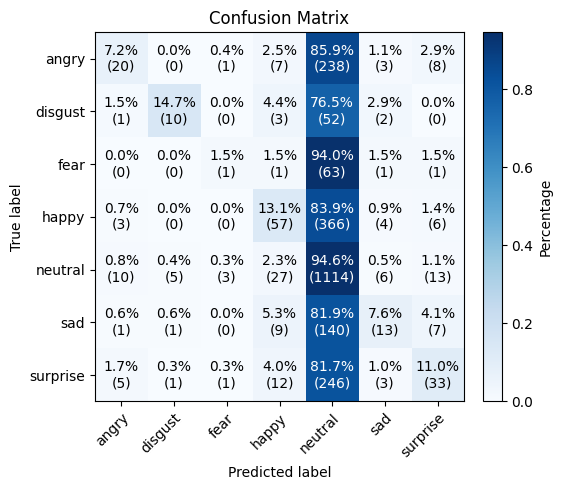

              precision    recall  f1-score   support

       angry       0.23      0.03      0.05       345
     disgust       0.25      0.04      0.07        68
        fear       0.00      0.00      0.00        50
       happy       0.39      0.11      0.17       402
     neutral       0.50      0.93      0.65      1256
         sad       0.35      0.03      0.06       208
    surprise       0.26      0.07      0.11       281

    accuracy                           0.48      2610
   macro avg       0.28      0.17      0.16      2610
weighted avg       0.39      0.48      0.36      2610



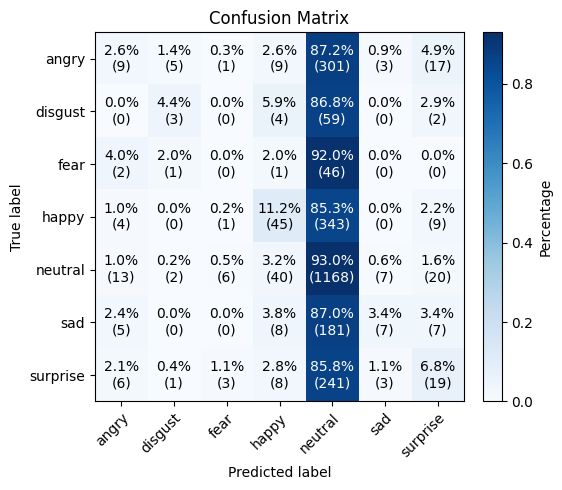

In [26]:
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from src.evaluation import plot_confusion_matrix

ft_rf = Pipeline([
        #('emb', FastTextTransformer()),
        #('Word2Vec', Word2VecTransformer(size=300)),
        ('GloVe', GloVeTransformer(size=300)),
        ('scaler', StandardScaler()),
        #('feature_selection1', FeatureSelector(algorithm="algorithm1", L=0.80, dispersion_measure="MAD", similarity_measure="AC")),
        #('scaler2', StandardScaler()),
        #('feature_selection2', FeatureSelector(algorithm="algorithm2", L=0.90, MS=0.75, dispersion_measure="MAD", similarity_measure="AC")),
        #('clf', RandomForestClassifier(n_estimators=100)) #w2v
        #('clf', RandomForestClassifier(n_estimators=50)) #FT
        #('clf', SVC(C=100, kernel='rbf')) #w2v
        ('clf', LogisticRegression(C=0.1)) #FT
        #('clf', SVC(C=10, kernel='rbf')) #Glove
    ])

iemocap['Utterance'] = iemocap['transcription']
df = pd.concat([
    #iemocap[['Utterance', 'label']], 
    meld_train[['Utterance', 'label']],
    #isear[['Utterance', 'label']],
    #emory[['Utterance', 'label']],
    ])
X_train, X_test, y_train, y_test = train_test_split(df['Utterance'], df['label'], stratify=df['label'], random_state=6)

ft_rf.fit(meld_train['Utterance'], meld_train['label'])
#ft_rf.fit(iemocap['transcription'], iemocap['label'])
#ft_rf.fit(X_train, y_train)

y_pred = ft_rf.predict(X_test)
print(classification_report(y_test, y_pred))
plot_confusion_matrix(y_test, y_pred)

meld_test['pred_ft_rf'] = ft_rf.predict(meld_test['Utterance'])
print(classification_report(meld_test['label'], meld_test['pred_ft_rf']))
plot_confusion_matrix(meld_test['label'], meld_test['pred_ft_rf'])


#iemocap['pred_ft_rf'] = ft_rf.predict(iemocap['transcription'])
#print(classification_report(iemocap['label'], iemocap['pred_ft_rf']))
#plot_confusion_matrix(iemocap['label'], iemocap['pred_ft_rf'])

In [ ]:
df = pd.read_csv("MELD_transcripts.csv")
df.head()

,Sr No.,Utterance,Speaker,Emotion,Sentiment,Dialogue_ID,Utterance_ID,Season,Episode,StartTime,EndTime,filename,label,text
0,1,Why do all youre coffee mugs have numbers on ...,Mark,surprise,positive,0,0,3,19,"00:14:38,127","00:14:40,378",/Users/krazmic/.cache/kagglehub/datasets/bhand...,surprise,Why do all your coffee mugs have numbers on t...
1,2,Oh. Thats so Monica can keep track. That way ...,Rachel,anger,negative,0,1,3,19,"00:14:40,629","00:14:47,385",/Users/krazmic/.cache/kagglehub/datasets/bhand...,angry,"Uh, at some Monica can keep track. That way, ..."
2,3,Y'know what?,Rachel,neutral,neutral,0,2,3,19,"00:14:56,353","00:14:57,520",/Users/krazmic/.cache/kagglehub/datasets/bhand...,neutral,You know what?
3,19,"Come on, Lydia, you can do it.",Joey,neutral,neutral,1,0,1,23,"0:10:44,769","0:10:46,146",/Users/krazmic/.cache/kagglehub/datasets/bhand...,neutral,"Come on, lady, you can do it. Push."
4,20,Push!,Joey,joy,positive,1,1,1,23,"0:10:46,146","0:10:46,833",/Users/krazmic/.cache/kagglehub/datasets/bhand...,happy,Push


In [ ]:
df['text'] = df['Utterance']

In [4]:
results, grid = run_experiment(df)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END .....................clf__C=0.1, clf__kernel=linear; total time=   0.8s
[CV] END .....................clf__C=0.1, clf__kernel=linear; total time=   0.8s
[CV] END .....................clf__C=0.1, clf__kernel=linear; total time=   0.8s
[CV] END .....................clf__C=0.1, clf__kernel=linear; total time=   0.8s
[CV] END ........................clf__C=0.1, clf__kernel=rbf; total time=   0.5s
[CV] END ........................clf__C=0.1, clf__kernel=rbf; total time=   0.5s
[CV] END ........................clf__C=0.1, clf__kernel=rbf; total time=   0.5s
[CV] END .....................clf__C=0.1, clf__kernel=linear; total time=   0.8s
[CV] END ........................clf__C=0.1, clf__kernel=rbf; total time=   0.6s
[CV] END ........................clf__C=0.1, clf__kernel=rbf; total time=   0.6s
[CV] END .......................clf__C=1, clf__kernel=linear; total time=   2.1s
[CV] END .......................clf__C=1, clf__ke

In [5]:
#grid.best_estimator_
for k, v in results.items():
    print(k, v)
for k, v in grid.items():
    print(k, v.best_params_)

('Word2Vec', 'SVM') 0.5042145593869731
('Word2Vec', 'RandomForest') 0.503448275862069
('Word2Vec', 'NaiveBayes') 0.10727969348659003
('Word2Vec', 'LogReg') 0.4911877394636015
('GloVe', 'SVM') 0.4854406130268199
('GloVe', 'RandomForest') 0.4766283524904214
('GloVe', 'NaiveBayes') 0.10421455938697317
('GloVe', 'LogReg') 0.46743295019157083
('FastText', 'SVM') 0.5099616858237548
('FastText', 'RandomForest') 0.510727969348659
('FastText', 'NaiveBayes') 0.1954022988505747
('FastText', 'LogReg') 0.4942528735632184
('Word2Vec', 'SVM') {'clf__C': 10, 'clf__kernel': 'rbf'}
('Word2Vec', 'RandomForest') {'clf__n_estimators': 100}
('Word2Vec', 'NaiveBayes') {}
('Word2Vec', 'LogReg') {'clf__C': 0.1}
('GloVe', 'SVM') {'clf__C': 0.1, 'clf__kernel': 'linear'}
('GloVe', 'RandomForest') {'clf__n_estimators': 100}
('GloVe', 'NaiveBayes') {}
('GloVe', 'LogReg') {'clf__C': 0.1}
('FastText', 'SVM') {'clf__C': 1, 'clf__kernel': 'rbf'}
('FastText', 'RandomForest') {'clf__n_estimators': 50}
('FastText', 'Naive

In [ ]:
results_fs, grid_fs = run_experiment(df)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Alg. 1: Selected top 80 features out of 100 total features.
Alg. 2: Selected 1 features out of 80 total features.
Alg. 1: Selected top 80 features out of 100 total features.
Alg. 2: Selected 1 features out of 80 total features.
Alg. 1: Selected top 80 features out of 100 total features.
Alg. 2: Selected 1 features out of 80 total features.
Alg. 1: Selected top 80 features out of 100 total features.
Alg. 2: Selected 1 features out of 80 total features.
[CV] END .....................clf__C=0.1, clf__kernel=linear; total time=   0.2s
[CV] END .....................clf__C=0.1, clf__kernel=linear; total time=   0.2s
[CV] END .....................clf__C=0.1, clf__kernel=linear; total time=   0.2s
[CV] END .....................clf__C=0.1, clf__kernel=linear; total time=   0.2s
Alg. 1: Selected top 80 features out of 100 total features.
Alg. 2: Selected 1 features out of 80 total features.
Alg. 1: Selected top 80 features out of 100 to

In [ ]:
print("Results WITH FEATURE SELECTION:")
for k, v in results_fs.items():
    print(k, v)
for k, v in grid_fs.items():
    print(k, v.best_params_)

{'clf__C': 0.1}

In [21]:
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm
tqdm.pandas()

iemocap = pd.read_csv("IEMOCAP_transcripts.csv")

model = grid.best_estimator_
iemocap['text'] = iemocap['text'].fillna("").astype(str)
iemocap['preds'] = model.predict(iemocap['text'])

print(classification_report(iemocap['label'], iemocap['preds']))


              precision    recall  f1-score   support

       angry       0.46      0.19      0.27      1103
     disgust       0.00      0.00      0.00         2
        fear       0.00      0.00      0.00        40
       happy       0.25      0.10      0.15       595
     neutral       0.39      0.80      0.52      1708
         sad       0.33      0.06      0.10      1084
    surprise       0.12      0.20      0.15       107

    accuracy                           0.37      4639
   macro avg       0.22      0.19      0.17      4639
weighted avg       0.36      0.37      0.30      4639



In [24]:
model.named_steps['clf']  # gives you the classifier (e.g. SVC())
model.named_steps['emb']  # gives you the embedding transformer


,lang,'en'
,reduce_to,None


In [22]:
model_fs = grid_fs.best_estimator_

iemocap['preds_fs'] = model_fs.predict(iemocap['text'])

print(classification_report(iemocap['label'], iemocap['preds_fs']))

              precision    recall  f1-score   support

       angry       0.43      0.14      0.22      1103
     disgust       0.00      0.00      0.00         2
        fear       0.00      0.00      0.00        40
       happy       0.23      0.10      0.14       595
     neutral       0.38      0.82      0.52      1708
         sad       0.46      0.05      0.09      1084
    surprise       0.14      0.24      0.18       107

    accuracy                           0.37      4639
   macro avg       0.23      0.19      0.16      4639
weighted avg       0.38      0.37      0.29      4639



In [ ]:
print(model_fs.named_steps['clf']) # gives you the classifier (e.g. SVC())
print(model_fs.named_steps['emb']) # gives you the embedding transformer
print(model_fs.named_steps['feature_selection1'])  

LogisticRegression(C=0.1, max_iter=1000)
FastTextTransformer()
FeatureSelector(L=0.8, algorithm='algorithm1', dispersion_measure='MAD')


GLoVe

In [17]:
results = run_experiment(df)
print("Results:")
for k, v in results.items():
    print(k, v)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[========================================----------] 81.1% 103.9/128.1MB downloadeddMB downloaded
[====================------------------------------] 40.1% 51.4/128.1MB downloadeded
[===========================-----------------------] 55.4% 71.0/128.1MB downloaded[CV] END ........................clf__C=0.1, clf__kernel=rbf; total time=  12.6s
[======================================------------] 77.6% 99.4/128.1MB downloadeddd
[==========================================--------] 85.9% 110.1/128.1MB downloaded[CV] END ........................clf__C=0.1, clf__kernel=rbf; total time=  19.2s
[=========================================---------] 82.4% 105.5/128.1MB downloadedd
[===========================================-------] 87.1% 111.6/128.1MB downloaded[CV] END .....................clf__C=0.1, clf__kernel=linear; total time=  20.8s
[==============================================----] 94.0% 120.3/128.1MB downloadedd
[==========

/Users/krazmic/Documents/GitHub/Repos/EmoReA/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:516: FitFailedWarning: 
7 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
6 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/krazmic/Documents/GitHub/Repos/EmoReA/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/krazmic/Documents/GitHub/Repos/EmoReA/.venv/lib/python3.11/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/U

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] END ...............................clf__n_estimators=50; total time=   0.1s
[CV] END ...............................clf__n_estimators=50; total time=   0.1s
[CV] END ...............................clf__n_estimators=50; total time=  17.4s
[CV] END ...............................clf__n_estimators=50; total time=  17.4s
[CV] END ...............................clf__n_estimators=50; total time=  17.4s
[CV] END ..............................clf__n_estimators=100; total time=  17.7s
[CV] END ..............................clf__n_estimators=100; total time=  18.0s
[CV] END ..............................clf__n_estimators=100; total time=  18.1s
[CV] END ..............................clf__n_estimators=100; total time=  18.3s
[CV] END ..............................clf__n_estimators=100; total time=  18.3s


/Users/krazmic/Documents/GitHub/Repos/EmoReA/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:516: FitFailedWarning: 
2 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/krazmic/Documents/GitHub/Repos/EmoReA/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/krazmic/Documents/GitHub/Repos/EmoReA/.venv/lib/python3.11/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/U

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END .................................................... total time=  13.3s
[CV] END .................................................... total time=  13.4s
[CV] END .................................................... total time=  13.4s
[CV] END .................................................... total time=  13.5s
[CV] END .................................................... total time=  13.5s
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END .........................................clf__C=0.1; total time=  15.0s
[CV] END .........................................clf__C=0.1; total time=  15.0s
[CV] END ...........................................clf__C=1; total time=  15.0s
[CV] END .........................................clf__C=0.1; total time=  15.1s
[CV] END .........................................clf__C=0.1; total time=  15.2s
[CV] END ...........................................clf__C=1; total tim

In [18]:
results = run_experiment(df)
print("Results:")
print("WITH FEATURE SELECTION")
for k, v in results.items():
    print(k, v)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Alg. 1: Selected top 80 features out of 100 total features.
Alg. 1: Selected top 80 features out of 100 total features.
Alg. 1: Selected top 80 features out of 100 total features.
Alg. 1: Selected top 80 features out of 100 total features.
[CV] END .....................clf__C=0.1, clf__kernel=linear; total time=  12.4s
[CV] END .....................clf__C=0.1, clf__kernel=linear; total time=  12.4s
[CV] END .....................clf__C=0.1, clf__kernel=linear; total time=  12.4s
[CV] END .....................clf__C=0.1, clf__kernel=linear; total time=  12.4s
Alg. 1: Selected top 80 features out of 100 total features.
Alg. 1: Selected top 80 features out of 100 total features.
Alg. 1: Selected top 80 features out of 100 total features.
Alg. 1: Selected top 80 features out of 100 total features.
[CV] END ........................clf__C=0.1, clf__kernel=rbf; total time=  12.0s
[CV] END ........................clf__C=0.1, clf__kerne

Word2Vec

In [6]:
results = run_experiment(df)
print("Results:")
for k, v in results.items():
    print(k, v)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END .....................clf__C=0.1, clf__kernel=linear; total time=  34.4s
[CV] END .....................clf__C=0.1, clf__kernel=linear; total time=  34.4s
[CV] END .....................clf__C=0.1, clf__kernel=linear; total time=  34.4s
[CV] END .....................clf__C=0.1, clf__kernel=linear; total time=  34.5s
[CV] END ........................clf__C=0.1, clf__kernel=rbf; total time=  30.7s
[CV] END ........................clf__C=0.1, clf__kernel=rbf; total time=  30.7s
[CV] END ........................clf__C=0.1, clf__kernel=rbf; total time=  30.8s
[CV] END .....................clf__C=0.1, clf__kernel=linear; total time=  30.9s
[CV] END ........................clf__C=0.1, clf__kernel=rbf; total time=  32.7s
[CV] END ........................clf__C=0.1, clf__kernel=rbf; total time=  32.8s
[CV] END .......................clf__C=1, clf__kernel=linear; total time=  34.6s
[CV] END .......................clf__C=1, clf__ke

FastText

In [22]:
results = run_experiment(df)
print("Results:")
print("WITH FEATURE SELECTION")
for k, v in results.items():
    print(k, v)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Alg. 1: Selected top 240 features out of 300 total features.Alg. 1: Selected top 240 features out of 300 total features.

Alg. 1: Selected top 240 features out of 300 total features.
Alg. 1: Selected top 240 features out of 300 total features.
[CV] END .....................clf__C=0.1, clf__kernel=linear; total time=  32.4s
[CV] END .....................clf__C=0.1, clf__kernel=linear; total time=  32.4s
[CV] END .....................clf__C=0.1, clf__kernel=linear; total time=  32.4s
[CV] END .....................clf__C=0.1, clf__kernel=linear; total time=  32.4s
Alg. 1: Selected top 240 features out of 300 total features.
Alg. 1: Selected top 240 features out of 300 total features.
Alg. 1: Selected top 240 features out of 300 total features.
Alg. 1: Selected top 240 features out of 300 total features.
[CV] END ........................clf__C=0.1, clf__kernel=rbf; total time=  29.9s
[CV] END ........................clf__C=0.1, cl

### Fine-tune BERT and RoBERTa models

In [13]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from datasets import Dataset, DatasetDict
from transformers import (AutoTokenizer, AutoConfig, AutoModelForSequenceClassification,
                          DataCollatorWithPadding, TrainingArguments, Trainer)
from sklearn.model_selection import train_test_split
import evaluate
import numpy as np
import os, sys, json
module_path = os.path.abspath(os.path.join('..', '..')) # or the path to your source code
sys.path.insert(0, module_path)
from src.data_loading import load_emorynlp, load_isear, load_daily_dialog, filter_emotions, load_iemocap, load_meld
from src.processor import FileProcessor
from tqdm import tqdm
tqdm.pandas()

#df = filter_emotions(load_emorynlp(split="train"))
#df = filter_emotions(load_isear())
#df = filter_emotions(load_daily_dialog(split="train")).sample(5000)
df = filter_emotions(load_meld(split="train")).rename({"Utterance": "text"}, axis=1)
meld_test = filter_emotions(load_meld()).rename({"Utterance": "text"}, axis=1)

train_df, val_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df['label'])
#val_df, test_df = train_test_split(val_df, test_size=0.5, random_state=42, stratify=val_df['label'])
test_df = meld_test

test_df.head()

Subfolders in the dataset: ['JSON files', 'MELD.Raw']
Subfolders in the raw data: ['dia47_utt11.mp4', 'dia35_utt2.mp4', 'dia956_utt14.mp4', 'dia1032_utt1.mp4', 'dia47_utt9.mp4', 'dia645_utt11.mp4', 'dia572_utt20.mp4', 'dia457_utt2.mp4', 'dia969_utt0.mp4', 'dia232_utt4.mp4', 'dia940_utt7.mp4', 'dia619_utt5.mp4', 'dia1033_utt1.mp4', 'dia46_utt9.mp4', 'dia456_utt2.mp4', 'dia34_utt2.mp4', 'dia630_utt2.mp4', 'dia424_utt9.mp4', 'dia941_utt7.mp4', 'dia288_utt16.mp4', 'dia968_utt0.mp4', 'dia351_utt14.mp4', 'dia752_utt6.mp4', 'dia351_utt0.mp4', 'dia823_utt3.mp4', 'dia851_utt8.mp4', 'dia810_utt14.mp4', 'dia137_utt0.mp4', 'dia379_utt7.mp4', 'dia136_utt0.mp4', 'dia822_utt3.mp4', 'dia350_utt0.mp4', 'dia206_utt6.mp4', 'dia782_utt5.mp4', 'dia1006_utt3.mp4', 'dia28_utt7.mp4', 'dia195_utt8.mp4', 'dia463_utt0.mp4', 'dia605_utt0.mp4', 'dia334_utt10.mp4', 'dia933_utt10.mp4', 'dia783_utt5.mp4', 'dia975_utt5.mp4', 'dia207_utt6.mp4', 'dia823_utt12.mp4', 'dia604_utt0.mp4', 'dia29_utt7.mp4', 'dia380_utt3.mp4',

,Sr No.,text,Speaker,Emotion,Sentiment,Dialogue_ID,Utterance_ID,Season,Episode,StartTime,EndTime,filename,label
0,1,Why do all youre coffee mugs have numbers on ...,Mark,surprise,positive,0,0,3,19,"00:14:38,127","00:14:40,378",/Users/krazmic/.cache/kagglehub/datasets/bhand...,surprise
1,2,Oh. Thats so Monica can keep track. That way ...,Rachel,anger,negative,0,1,3,19,"00:14:40,629","00:14:47,385",/Users/krazmic/.cache/kagglehub/datasets/bhand...,angry
2,3,Y'know what?,Rachel,neutral,neutral,0,2,3,19,"00:14:56,353","00:14:57,520",/Users/krazmic/.cache/kagglehub/datasets/bhand...,neutral
3,19,"Come on, Lydia, you can do it.",Joey,neutral,neutral,1,0,1,23,"0:10:44,769","0:10:46,146",/Users/krazmic/.cache/kagglehub/datasets/bhand...,neutral
4,20,Push!,Joey,joy,positive,1,1,1,23,"0:10:46,146","0:10:46,833",/Users/krazmic/.cache/kagglehub/datasets/bhand...,happy


In [ ]:
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
os.environ["PYTORCH_MPS_DISABLE"] = "1"
import torch

device = torch.device("cpu")  # change to "mps" if you want to use Apple GPU



# ===========
# 2) encode labels (string -> int)
# ===========
le = LabelEncoder()
le.fit(train_df["label"])

train_df["label_id"] = le.transform(train_df["label"])
val_df["label_id"]   = le.transform(val_df["label"])
test_df["label_id"]  = le.transform(test_df["label"])

id2label = {i: l for i, l in enumerate(le.classes_)}
label2id = {l: i for i, l in id2label.items()}

print("Classes:", id2label)


# ===========
# 3) Convert pandas -> Hugging Face Dataset
# ===========
train_ds = Dataset.from_pandas(train_df[["text","label_id"]].rename(columns={"label_id":"labels"}))
val_ds   = Dataset.from_pandas(val_df[["text","label_id"]].rename(columns={"label_id":"labels"}))
test_ds  = Dataset.from_pandas(test_df[["text","label_id"]].rename(columns={"label_id":"labels"}))

dataset = DatasetDict({
    "train": train_ds,
    "validation": val_ds,
    "test": test_ds
})

# ===========
# 4) Tokenizer & model
# ===========
#model_name = "albert-base-v2" # MELD - 
model_name = "distilbert-base-multilingual-cased"
#model_name = "bert-base-cased"
#model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
#model_name = "xlm-roberta-base"
#model_name = "cardiffnlp/twitter-xlm-roberta-base-emotion"#"distilroberta-base"
#model_name = "meta-llama/Llama-3.2-1B" #"cardiffnlp/twitter-xlm-roberta-base-emotion"
tok = AutoTokenizer.from_pretrained(model_name)

def tokenize(batch):
    return tok(batch["text"], truncation=True, max_length=64) #128



dataset_tok = dataset.map(tokenize, batched=True)
collator = DataCollatorWithPadding(tokenizer=tok)

cfg = AutoConfig.from_pretrained(model_name, num_labels=len(le.classes_), id2label=id2label, label2id=label2id)
model = AutoModelForSequenceClassification.from_pretrained(model_name, config=cfg)

# ===========
# 5) Metrics
# ===========
acc = evaluate.load("accuracy")
f1 = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": acc.compute(predictions=preds, references=labels)["accuracy"],
        "f1_macro": f1.compute(predictions=preds, references=labels, average="macro")["f1"],
    }

# ===========
# 6) Trainer
# ===========
args = TrainingArguments(
    output_dir=model_name+"_train",#"mdistilbert_emotions",
    no_cuda=True,
    #eval_strategy="epoch",
    evaluation_strategy="epoch",#"epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=4,#16,
    per_device_eval_batch_size=8,#32,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy", #"f1_macro",
    logging_steps=50,
    report_to="none",
    #gradient_accumulation_steps=4,
    #bf16=True,
    #fp16=True,
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=dataset_tok["train"],
    eval_dataset=dataset_tok["validation"],
    tokenizer=tok,
    data_collator=collator,
    compute_metrics=compute_metrics,
)

# ===========
# 7) Train and evaluate
# ===========
trainer.train()
print("Final test results:", trainer.evaluate(dataset_tok["test"]))

# distilbert emodb+tess--iemocap 3ep 21,09

Classes: {0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprise'}


Map: 100%|██████████| 2610/2610 [00:00<00:00, 80839.57 examples/s]
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the latest cached version of the module from /Users/krazmic/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--accuracy/f887c0aab52c2d38e1f8a215681126379eca617f96c447638f751434e8e65b14 (last modified on Wed Sep 10 18:03:35 2025) since it couldn't be found locally at evaluate-metric--accuracy, or remotely on the Hugging Face Hub.
Using the latest cached version of the module from /Users/krazmic/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--f1/34c46321f42186df33a6260966e34a368f14868d9cc2ba47d142112e2800d233 (last modif

{'loss': 1.6912, 'grad_norm': 5.069285869598389, 'learning_rate': 4.952326468344775e-05, 'epoch': 0.03}


  2%|▏         | 100/5244 [00:30<26:57,  3.18it/s]

{'loss': 1.5237, 'grad_norm': 14.854215621948242, 'learning_rate': 4.90465293668955e-05, 'epoch': 0.06}


  3%|▎         | 150/5244 [00:45<24:44,  3.43it/s]

{'loss': 1.5103, 'grad_norm': 4.195149898529053, 'learning_rate': 4.8569794050343255e-05, 'epoch': 0.09}


  4%|▍         | 200/5244 [01:00<25:04,  3.35it/s]

{'loss': 1.3864, 'grad_norm': 6.019711971282959, 'learning_rate': 4.8093058733791e-05, 'epoch': 0.11}


  5%|▍         | 250/5244 [01:15<24:49,  3.35it/s]

{'loss': 1.3493, 'grad_norm': 15.313089370727539, 'learning_rate': 4.761632341723875e-05, 'epoch': 0.14}


  6%|▌         | 300/5244 [01:29<24:46,  3.33it/s]

{'loss': 1.3427, 'grad_norm': 11.472090721130371, 'learning_rate': 4.71395881006865e-05, 'epoch': 0.17}


  7%|▋         | 350/5244 [01:44<23:50,  3.42it/s]

{'loss': 1.4216, 'grad_norm': 9.611681938171387, 'learning_rate': 4.666285278413425e-05, 'epoch': 0.2}


  8%|▊         | 400/5244 [01:59<23:54,  3.38it/s]

{'loss': 1.1941, 'grad_norm': 4.824985504150391, 'learning_rate': 4.6186117467582e-05, 'epoch': 0.23}


  9%|▊         | 450/5244 [02:14<23:21,  3.42it/s]

{'loss': 1.3097, 'grad_norm': 5.316991329193115, 'learning_rate': 4.570938215102975e-05, 'epoch': 0.26}


 10%|▉         | 500/5244 [02:29<23:36,  3.35it/s]

{'loss': 1.5827, 'grad_norm': 7.985111713409424, 'learning_rate': 4.52326468344775e-05, 'epoch': 0.29}


 10%|█         | 550/5244 [02:44<24:13,  3.23it/s]

{'loss': 1.3935, 'grad_norm': 7.288054943084717, 'learning_rate': 4.475591151792525e-05, 'epoch': 0.31}


 11%|█▏        | 600/5244 [02:59<23:19,  3.32it/s]

{'loss': 1.3007, 'grad_norm': 6.151566505432129, 'learning_rate': 4.4279176201373e-05, 'epoch': 0.34}


 12%|█▏        | 604/5244 [03:00<23:49,  3.25it/s]

In [ ]:
df.label.value_counts()

In [ ]:
save_dir = "./emotion_model_distilbert"

# Save model, tokenizer, and config
trainer.save_model(save_dir)
tok.save_pretrained(save_dir)

# Save label maps
import json
with open(os.path.join(save_dir, "label_map.json"), "w") as f:
    json.dump({"id2label": id2label, "label2id": label2id}, f)


ISEAR - distilbert - 87,4%

EmoryNLP - distilbert - 53%

DailyDialog - distilbert - 82,26%

MELD - distilbert -

IEMOCAP - distilbert -

In [ ]:
from sklearn.metrics import classification_report
# EmoryNLP
preds = trainer.predict(dataset_tok["test"])
print(classification_report(preds.label_ids, np.argmax(preds.predictions, axis=1), target_names=le.classes_))

100%|██████████| 135/135 [00:08<00:00, 16.69it/s]

              precision    recall  f1-score   support

        fear       0.42      0.36      0.39       193
       happy       0.56      0.56      0.56       328
     neutral       0.59      0.65      0.62       456
         sad       0.30      0.24      0.27       100

    accuracy                           0.53      1077
   macro avg       0.47      0.45      0.46      1077
weighted avg       0.52      0.53      0.53      1077



100%|██████████| 135/135 [00:07<00:00, 17.08it/s]


              precision    recall  f1-score   support

        fear       0.42      0.36      0.39       193
       happy       0.56      0.56      0.56       328
     neutral       0.59      0.65      0.62       456
         sad       0.30      0.24      0.27       100

    accuracy                           0.53      1077
   macro avg       0.47      0.45      0.46      1077
weighted avg       0.52      0.53      0.53      1077



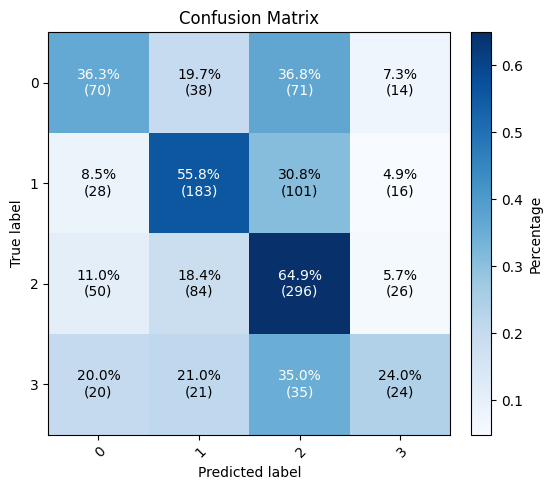

In [ ]:
from src.evaluation import plot_confusion_matrix

preds = trainer.predict(dataset_tok["test"])
y_true = preds.label_ids
y_pred = np.argmax(preds.predictions, axis=1)
# Convert numeric predictions/labels back to text
y_true_labels = le.inverse_transform(y_true)
y_pred_labels = le.inverse_transform(y_pred)
print(classification_report(y_true, y_pred, target_names=le.classes_))
plot_confusion_matrix(y_true_labels, y_pred_labels)

100%|██████████| 49/49 [00:02<00:00, 22.06it/s]


              precision    recall  f1-score   support

       angry       0.45      0.42      0.44        52
     disgust       0.00      0.00      0.00        10
        fear       0.00      0.00      0.00         7
       happy       0.43      0.52      0.47        61
     neutral       0.68      0.90      0.77       189
         sad       0.00      0.00      0.00        31
    surprise       0.67      0.29      0.40        42

    accuracy                           0.60       392
   macro avg       0.32      0.30      0.30       392
weighted avg       0.52      0.60      0.55       392

MELD


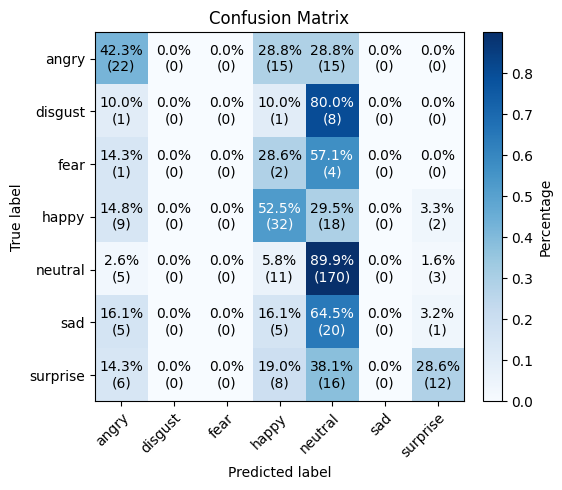

In [10]:
from src.evaluation import plot_confusion_matrix
from sklearn.metrics import classification_report

preds = trainer.predict(dataset_tok["test"])
y_true = preds.label_ids
y_pred = np.argmax(preds.predictions, axis=1)
# Convert numeric predictions/labels back to text
y_true_labels = le.inverse_transform(y_true)
y_pred_labels = le.inverse_transform(y_pred)
print(classification_report(y_true, y_pred, target_names=le.classes_))
print("MELD")
plot_confusion_matrix(y_true_labels, y_pred_labels)

## Experiment 3: Train and Fine-Tune Models (Cross-Corpus Generalization)

## Experiment 4: Train and Fine-Tune Models (Multi-Corpus Training)